This tutorial will get you up and running using `ParticleInCell2` by showing
you how to model one of the simplest phenomena in plasma physics: an
electrostatic (or Langmuir) oscillation.

A Langmuir oscillation occurs when a slab of charge in a uniform plasma is
displaced. The resulting charge density gradient creates a restoring force
that causes the displaced slab of charge to return to its original position.
But---just as in a classical pendulum oscillation---the momentum of the
charge carries it past its equilibrium point, creating an opposite charge
gradient, and a restoring force in the opposite direction. As a result, the
slab of charge oscillates around its equilibrium forever (at least in this
idealized model that ignores possible damping mechanisms).

To start using `ParticleInCell2`, we must first install and load the package.
As the package is not currently registered in Julia's General registry, we
will using `Pkg`s `develop` function. We will also need the `StaticArrays`
package, so we load that now.
We will use `CairoMakie` which is a backend for [`Makie`](https://makie.org)
that can generate beautiful, publication-quality graphics.

In [1]:
using ParticleInCell2
using StaticArrays
using CairoMakie
CairoMakie.activate!(type = "svg") # hide

In order to simulate a plasma, we need to define a domain in which the
simulation will take place. Because Langmuir oscillations are a
one-dimensional phenomena, we will choose to perform a 1D simulation. We
arbitrarily choose to set the length of the simulation domain to 1, and we
choose to use 32 equally spaced (i.e. uniform) grid points. Additionally, we
make the simulation domain periodic.

In [2]:
sim_length = 1.0
num_cells = 32
periodic = true
grid = UniformCartesianGrid((0.0,), (sim_length,), (num_cells,), (periodic,));

Next, we set up the required fields for an electrostatic PIC simulation. In
a basic PIC cycle, we first compute the charge density, `rho`, on the grid
points. We then compute the corresponding electric potential, `phi`. The
electric field is conventionally determined in a two step process. First the
potential, which is locatated at the nodes of the grid cells, is finite
differenced to the edges of the cells, producing an edge electric field,
`Eedge`. The edge electric fields are then averaged to get the electric fields
located at the nodes, `Enode`.

When creating the fields, we must specify the underlying grid on which the
field is based, the location of the values of the field (i.e. are the field
values located at the nodes of each cell? The edge?), the dimension of the
field, and the number of guard cells surrounding the field.

In [3]:
field_dimension = 1
lower_guard_cells = 1
rho = Field(grid, ParticleInCell2.node, field_dimension, lower_guard_cells)
phi = Field(grid, ParticleInCell2.node, field_dimension, lower_guard_cells)
Eedge = Field(grid, ParticleInCell2.edge, field_dimension, lower_guard_cells)
Enode = Field(grid, ParticleInCell2.node, field_dimension, lower_guard_cells);

Now we need to create some macroparticles to move in the simulation. In
this example, we only consider mobile electrons. In order to seed a Langmuir
oscillation, we give the electrons a sinusoidal velocity perturbation.
Currently, the creation of a new particle species, and the specification of
all of the initial conditions is a quite manual process. In the future, this
will be streamlined.

In [4]:
nom_density = 1e14
dx = sim_length / num_cells
num_particles = num_cells * 10
particles_per_macro = nom_density * sim_length / num_particles
k = 1
amplitude = 1e3
thermal_amp = 0.0

elec_mass = 9e-31
positions = collect(0:num_particles-1) ./ num_particles
momentums =
    (particles_per_macro * elec_mass * amplitude) .* sin.(positions .* k .* 2pi) .+
    thermal_amp .* randn.()
electrons = ParticleInCell2.electrons(positions, momentums, particles_per_macro);

We can plot the initial positions and momentums of our electrons.

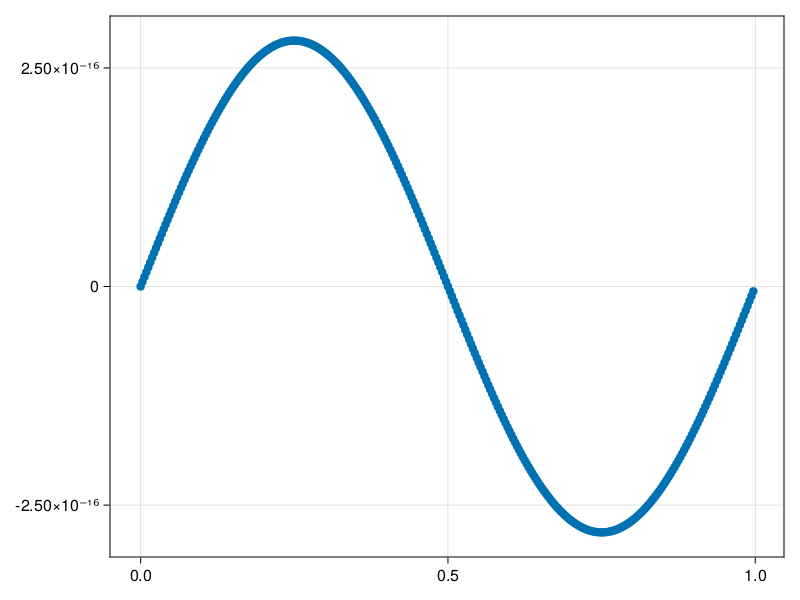

In [5]:
scatter(positions, momentums)

In the final step of the setup, we create all of the simulation steps
required to do the electrostatic simulation. In this tutorial, we will not
discuss the details of PIC simulation, but you can find more information about
the PIC simulation cycle elsewhere in this documentation.

Also at this point, we must choose a timestep for the simulation. The choice
of a timestep is a nuanced decision that balances limited compute time (which
encourages a longer timestep, so that more of the systems dynamics can be
observed with the same number of steps) with the physical and numerical
constraints imposed by the system, and the simulation method. In this case,
the physical constraint is that we must resolve the plasma frequency (the
frequency of the charge slab's oscillation) and the numerical constraint is
that we must respect the CFL condition, which says that particles may not
cross more than one cell per timestep.

In [6]:
dt = 1.11e-11 * 2

charge_interp = BSplineChargeInterpolation(electrons, rho, 1)
comm_rho = CommunicateGuardCells(rho, true)
field_solve = PoissonSolveFFT(rho, phi)
comm_phi = CommunicateGuardCells(phi)
finite_diff = FiniteDifferenceToEdges(phi, Eedge)
comm_Eedge = CommunicateGuardCells(Eedge)
elec_ave = AverageEdgesToNodes(Eedge, Enode)
comm_Enode = CommunicateGuardCells(Enode)
push = ElectrostaticParticlePush(electrons, Enode, dt)
comm_electrons = CommunicateSpecies(electrons, grid);

Now we are ready to run the simulation. We will simulate the plasma for 1000
timesteps, and at each step, we will calculate the electric field energy,
$$
U_E = \int |E(x)|^2 \,\mathrm{d}x.
$$
This field energy will oscillate as the electrons move in and out of
equilibrium, and so we can use it to observe the Langmuir oscillation.

In [7]:
n_steps = 1000

epsilon_0 = 8.8e-12
electric_field_energy = Vector{Float64}(undef, n_steps)

for n = 1:n_steps
    # Calculate the electric field energy
    electric_field_energy[n] = 0
    for I in eachindex(Enode)
        electric_field_energy[n] += (dx * epsilon_0 / 2) * (Enode.values[I])^2
    end

    # TODO
    rho.values .= 0

    step!(charge_interp)
    step!(comm_rho)
    step!(field_solve)
    step!(comm_phi)
    step!(finite_diff)
    step!(comm_Eedge)
    step!(elec_ave)
    step!(comm_Enode)
    step!(push)
    step!(comm_electrons)
end

We can now visualize the electric field energy to see the plasma oscillation.

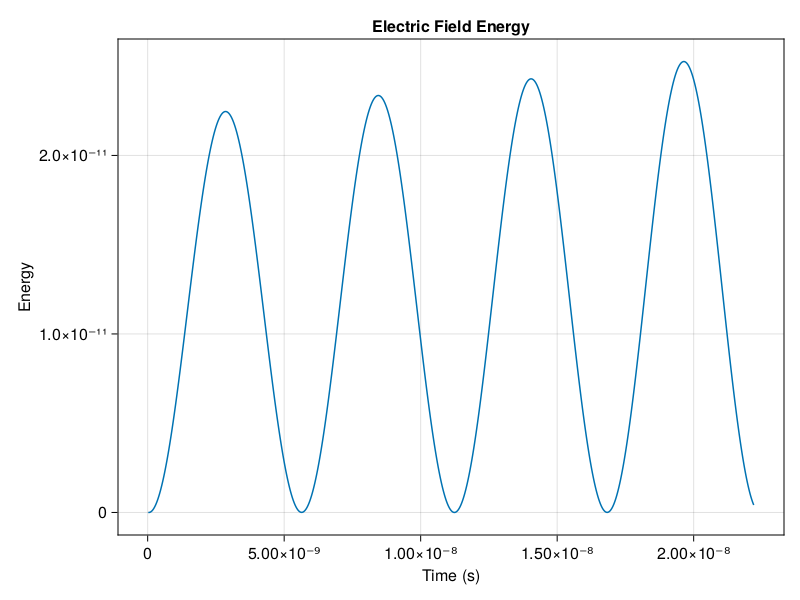

In [8]:
times = collect(range(1, n_steps)) .* dt
lines(
    times,
    electric_field_energy;
    axis = (; title = "Electric Field Energy", xlabel = "Time (s)", ylabel = "Energy"),
)

Notice that the electric field energy is slowly growing over time. This is a
result of the "grid-heating instability". In this instability, a plasma with
a Debye length (the characteristic length with which the plasma will screen
an applied electric field) shorter than the cell size will be unphysically
heated until the Debye length is comparable to the cell size. Because we
initialized the electrons with only a sinusoidal velocity perturbation, and
no thermal spread in the velocity distribution, the Debye length is
effectively zero, and thus the simulation suffers from grid heating.

Despite this unphysical effect, we can still use the electric field energy
time series to calculate the plasma frequency by computing its Fourier
transform. First, let's plot the Fourier transform.

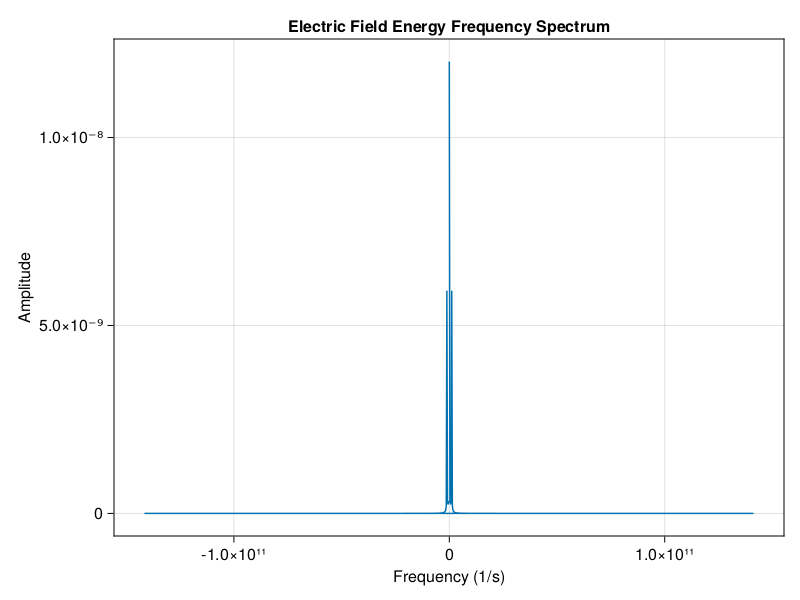

In [9]:
using FFTW

freqs = fftfreq(n_steps, 1 / dt) .* 2pi
freq_amps = abs.(fft(electric_field_energy))

lines(
    freqs,
    freq_amps;
    axis = (;
        title = "Electric Field Energy Frequency Spectrum",
        xlabel = "Frequency (1/s)",
        ylabel = "Amplitude",
    ),
)

It is hard to see what is happening at the low frequencies, so let's zoom
in on the positive low frequencies.

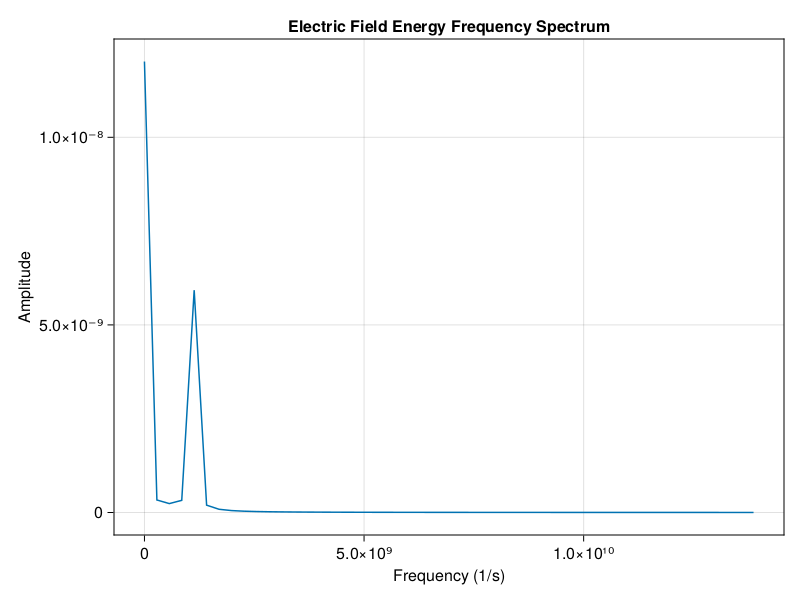

In [10]:
cutoff_index = round(Int, n_steps * 0.05)
lines(
    freqs[1:cutoff_index],
    freq_amps[1:cutoff_index];
    axis = (;
        title = "Electric Field Energy Frequency Spectrum",
        xlabel = "Frequency (1/s)",
        ylabel = "Amplitude",
    ),
)

Next, we find the maximum frequency. We don't care about the spike at zero
frequency (that is just a consequence of the grid heating that we discussed
earlier) so we first set its amplitude to zero, and then find the largest
remaining amplitude, and it's corresponding frequency.

In [11]:
freq_amps[1] = 0
max_index = findmax(freq_amps)[2]
max_freq = freqs[max_index]

# Divide by 2 because the electric field energy goes through a maximum twice
# per plasma oscillation, and take the absolute value because we don't care
# about the phase of the oscillation.
plasma_freq = abs(max_freq / 2)

5.660527303765392e8

Finally, we can compare this to the theoretically expected result:

In [12]:
elec_charge = 1.6e-19
elec_mass = 9e-31
expected_plasma_freq = sqrt(nom_density * elec_charge^2 / elec_mass / epsilon_0)

5.685352436149611e8

As you can see, these two results agree fairly closely, indicating that our
simulation has captured the essential physics that the theory predicts.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*